# CS Project 175 Phase 1

In [1]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install langdetect

In [2]:
import pandas as pd
import numpy as np

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing

import seaborn

# Analyzing the Data

In [3]:
data = pd.read_csv('./data/data.csv')
del data['Unnamed: 0']
data.head()

,title,genre,lyrics
0,the number of the beast,metal,woe to you o'er earth and sea\r\nfor the devil...
1,fear of the dark,metal,i am a man who walks alone\r\nand when i'm wal...
2,the trooper,metal,you'll take my life but i'll take yours too\r\...
3,hallowed be thy name,metal,i'm waiting in my cold cell when the bell begi...
4,run to the hills,metal,white man came across the sea\r\nhe brought us...


Num of rows 295268
biggest class:  118830
smallest class:  12668


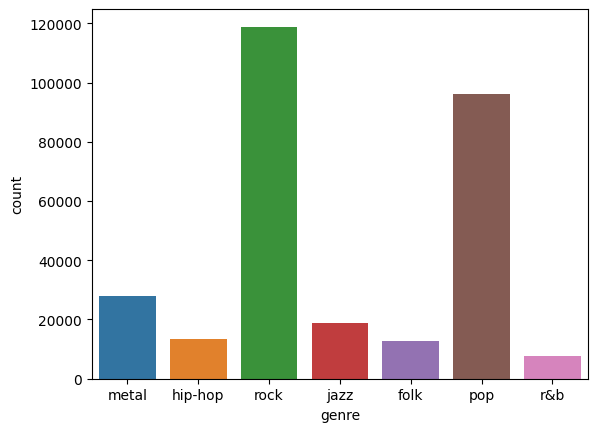

In [4]:
# plot labels
print('Num of rows', len(data))
seaborn.countplot(data, x='genre')
print('biggest class: ', (data['genre'] == max(data['genre'])).sum())
print('smallest class: ', (data['genre'] == min(data['genre'])).sum())


## Building the Pipeline

In [5]:
RANDOM_STATE = 42

def gather_data():
    data = pd.read_csv('./data/data.csv')
    return data['lyrics'], data['genre']

def vectorize_labels(labels, classes=None):
    '''
    Vectorizes the labels.
    Returns as (indexes, labels)
    '''
    if classes is None:
        return pd.factorize(labels)
    return pd.Categorical(labels, categories=classes).codes, classes

def features_bow(data):
    vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1, 2))
    text = data.to_list()
    X = vectorizer.fit_transform(text)
    return X, vectorizer

def train_model_logistic(X, Y):
    classifier = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial', random_state=RANDOM_STATE, fit_intercept=True)
    classifier.fit(X, Y)
    return classifier

def evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test):
    train_accuracy = model.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    print('\nTesting: ')
    test_accuracy = model.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # Compute and print AUC on the test data
    class_probabilities = model.predict_proba(X_test)
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities, multi_class='ovo')
    print(' AUC value:', format( 100*test_auc_score , '.2f') )

## Executing the Pipeline

In [6]:
# Phase 1 pipeline
inputs, labels = gather_data()

In [7]:
# convert to features
Y, classes = vectorize_labels(labels)
X, vectorizer = features_bow(inputs)

In [8]:
# split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=RANDOM_STATE)

In [9]:
# train model
model = train_model_logistic(X_train, Y_train)

c:\Users\ajiev\anaconda3\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluating the Model

In [10]:
evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test)


Training:
 accuracy: 57.21

Testing: 
 accuracy: 56.51
 AUC value: 81.33


In [11]:
def most_significant_terms(weights, vectorizer, K):
    pos_indices = np.argpartition(weights, -K)[-K:] # gather the K most positive indices
    pos_indices = pos_indices[np.argsort(-weights[pos_indices])] # sort the indices

    neg_indices = np.argpartition(weights, K)[:K] # gather the K most negative indices
    neg_indices = neg_indices[np.argsort(weights[neg_indices])] # sort the indices

    topK_pos_weights = weights[pos_indices]
    topK_neg_weights = weights[neg_indices]

    # gather the associated terms
    terms = vectorizer.get_feature_names_out()
    topK_pos_terms = terms[pos_indices]
    topK_neg_terms = terms[neg_indices]
        
    # print the positive weights and terms
    print('Top positive weights:')
    for i in range(len(topK_pos_weights)):
        print(format(topK_pos_weights[i], '.3f'), topK_pos_terms[i])
    
    # print the negative weights and terms
    print('Most negative weights:')
    for i in range(len(topK_neg_weights)):
        print(format(topK_neg_weights[i], '.3f'), topK_neg_terms[i])


In [12]:
classes

Index(['metal', 'hip-hop', 'rock', 'jazz', 'folk', 'pop', 'r&b'], dtype='object')

In [13]:
for i in range(len(classes)):
    print('Most Significant Terms for Class: "' + classes[i] + '"')
    most_significant_terms(model.coef_[i], vectorizer, 5)
    print()

Most Significant Terms for Class: "metal"
Top positive weights:
0.360 path
0.350 final
0.348 flesh
0.290 fucking
0.244 souls
Most negative weights:
-0.418 niggas
-0.418 nigga
-0.399 gon
-0.364 darling
-0.347 lovers

Most Significant Terms for Class: "hip-hop"
Top positive weights:
0.421 tryna
0.317 niggas
0.261 gon
0.235 lil
0.212 probably
Most negative weights:
-0.272 band
-0.238 ve got
-0.204 sea
-0.184 blues
-0.183 key

Most Significant Terms for Class: "rock"
Top positive weights:
0.215 cos
0.191 guitar
0.131 underneath
0.123 wasted
0.117 wife
Most negative weights:
-0.406 tryna
-0.286 mma
-0.277 niggas
-0.272 lil
-0.225 gon

Most Significant Terms for Class: "jazz"
Top positive weights:
0.360 thrill
0.356 folks
0.340 romance
0.305 kissed
0.267 breeze
Most negative weights:
-0.449 blood
-0.314 pain
-0.301 breathe
-0.298 hell
-0.271 ones

Most Significant Terms for Class: "folk"
Top positive weights:
0.216 sorrow
0.213 guitar
0.208 trees
0.203 wife
0.192 flowers
Most negative weight

In [14]:
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

np.random.seed(RANDOM_STATE)
NUM_EXAMPLES = 10
for _ in range(NUM_EXAMPLES):
    i = np.random.choice(np.where(predictions != Y_test)[0])
    print("Song Title:", data['title'][i])
    print('Predicted:', classes[predictions[i]], 'Actual:', classes[Y_test[i]])
    print('Probability:', probabilities[i][predictions[i]])
    print("Lyrics: ")
    print('"' + data['lyrics'][i][:100] + '..."')
    print()


Song Title: the brouhaha
Predicted: pop Actual: rock
Probability: 0.5077901516295492
Lyrics: 
"now what the blood clot i rap a lot what you gonna do when the beat goes drop? whatcha talkin' 'bout..."

Song Title: carry me on my way
Predicted: rock Actual: pop
Probability: 0.4878078920069306
Lyrics: 
"i forget what to ask for there isn't anything i haven't been given
how could i wish for anything mo..."

Song Title: the sound of silence
Predicted: pop Actual: hip-hop
Probability: 0.723721373220093
Lyrics: 
"hello darkness my old friend
i've come to talk with you again
because a vision softly creeping
le..."

Song Title: in the flesh
Predicted: rock Actual: r&b
Probability: 0.5543586980012779
Lyrics: 
"money talk these diamonds on my cavity
money talk

money talk these diamonds on my cavity
scoopi..."

Song Title: gender equality is a myth!
Predicted: pop Actual: rock
Probability: 0.4366823443492496
Lyrics: 
"we need to stop buying into the myth about gender equality it isn’t a reality y

<AxesSubplot: xlabel='genre', ylabel='count'>

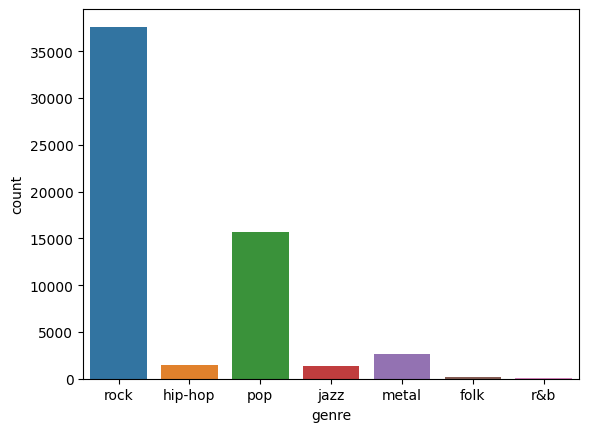

In [30]:
# Plot predictions to see distribution and if there is bias
test_predictions = [classes[i] for i in predictions]
test_predictions_df = pd.DataFrame(data=test_predictions, columns=["genre"])
seaborn.countplot(test_predictions_df, x="genre")